In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
import os
sys.path.append(os.path.abspath("/Users/Lyndon.Odia/Desktop/lo-devx/power-spread-option-pricing-main"))
from config import raw_data_dir, processed_data_dir, API_KEY, FR_DOMAIN, START_DATE, END_DATE, FX_GBP_EUR

In [11]:
# Load merged hourly dataset 
data_path = os.path.join(processed_data_dir, "UK_FR_day_ahead_hourly_merged_spread.csv")
df = pd.read_csv(data_path, parse_dates=["datetime"])

In [12]:
# Ensure sorted and clean
df = df.sort_values("datetime").reset_index(drop=True)

In [13]:
S1 = df["UK_price_eur"].mean()  # Mean UK price in EUR/MWh
S2 = df["FR_price"].mean()      # Mean FR price in EUR/MWh

# From return-based volatilities (already annualised in your EDA)
sigma1 = 16.08 / S1 #EUR/MWh
sigma2 = 68.60 / S2 #EUR/MWh
rho = 0.142   # Pearson correlation from returns

In [14]:
K = 0.76 # Strike price (capacity cost) in EUR/MWh - realistically this should be > 0 factoring in the actual cost to acqure interconnector rights
T = 1/12     # 1 month to expiry

In [15]:
try:
   S1, S2
except NameError:
   S1 = df["UK_price_eur"].mean()
   S2 = df["FR_price"].mean()
try:
   sigma1, sigma2
except NameError:
   rets = np.log(df[["UK_price_eur","FR_price"]]).diff().dropna()
   ann = np.sqrt(24*365)
   sigma1 = rets["UK_price_eur"].std() * ann
   sigma2 = rets["FR_price"].std() * ann
try:
   rho
except NameError:
   rho = np.log(df["UK_price_eur"]).diff().corr(np.log(df["FR_price"]).diff())
try:
   T
except NameError:
   T = 1/12
try:
   K
except NameError:
   K = 0.0
def kirk(F1, F2, s1, s2, r, T, K=0.0):
   b = F2 / (F2 + K)
   sigk = np.sqrt(s1**2 - 2*b*r*s1*s2 + (b**2)*(s2**2))
   d1 = (np.log(F1/(F2+K)) + 0.5*sigk**2*T) / (sigk*np.sqrt(T))
   d2 = d1 - sigk*np.sqrt(T)
   return F1*norm.cdf(d1) - (F2+K)*norm.cdf(d2)
def scale_to_capacity(price_eur_per_mwh, mw=1000, T_years=T):
   hours = 8760 * T_years
   return price_eur_per_mwh * mw * hours  # € for the block over T
print(f"Base inputs -> S1={S1:.2f}, S2={S2:.2f}, σ1={sigma1:.2f}, σ2={sigma2:.2f}, ρ={rho:.3f}, T={T:.3f}, K={K:.2f}")
base_kirk = kirk(S1,S2,sigma1,sigma2,rho,T,K)
print(f"Base Kirk price: {base_kirk:.2f} €/MWh  |  ~€{scale_to_capacity(base_kirk, 1000):,.0f} for 1 GW over T")

Base inputs -> S1=81.10, S2=68.06, σ1=0.20, σ2=1.01, ρ=0.142, T=0.083, K=0.76
Base Kirk price: 16.00 €/MWh  |  ~€11,680,264 for 1 GW over T


## Correlation sweep (rho)

,rho,kirk_eur_mwh
0,0.0,16.203301
1,0.1,16.060800
2,0.2,15.916315
3,0.3,15.769778
4,0.4,15.621118
5,0.5,15.470264
6,0.6,15.317144
7,0.7,15.161687
8,0.8,15.003823
9,0.9,14.843488


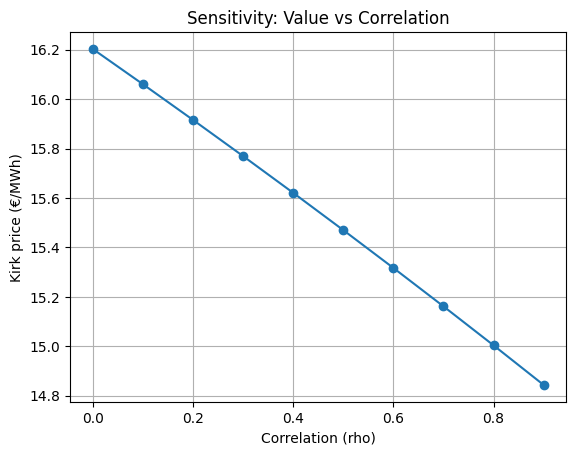

In [16]:
rhos = np.linspace(0.0, 0.9, 10)
vals = [kirk(S1,S2,sigma1,sigma2,r,T,K) for r in rhos]
corr_df = pd.DataFrame({"rho": rhos, "kirk_eur_mwh": vals})
display(corr_df)
plt.figure()
plt.plot(corr_df["rho"], corr_df["kirk_eur_mwh"], marker="o")
plt.xlabel("Correlation (rho)")
plt.ylabel("Kirk price (€/MWh)")
plt.title("Sensitivity: Value vs Correlation")
plt.grid(True)
plt.show()

## Volatility Sweep

,factor,kirk_ukOnly,kirk_frOnly,kirk_both
0,0.50,15.995177,13.008803,12.939302
1,0.75,15.988793,14.336591,14.307932
2,1.00,16.000362,16.000362,16.000362
3,1.25,16.029825,17.824631,17.838736
4,1.50,16.077029,19.729177,19.747750


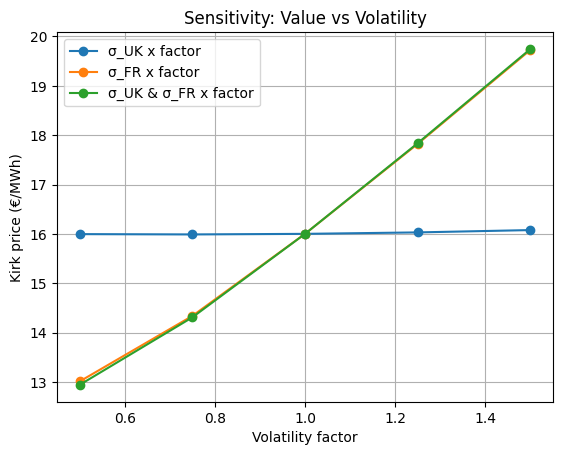

In [17]:
factors = [0.5, 0.75, 1.0, 1.25, 1.5]

# vary UK vol only (FR fixed)
vals_uk = [kirk(S1,S2,sigma1*f, sigma2, rho, T, K) for f in factors]

# vary FR vol only (UK fixed)
vals_fr = [kirk(S1,S2,sigma1, sigma2*f, rho, T, K) for f in factors]

# vary both vols together
vals_both = [kirk(S1,S2,sigma1*f, sigma2*f, rho, T, K) for f in factors]
vol_df = pd.DataFrame({
   "factor": factors,
   "kirk_ukOnly": vals_uk,
   "kirk_frOnly": vals_fr,
   "kirk_both": vals_both
})
display(vol_df)

plt.figure()
plt.plot(factors, vals_uk, marker="o", label="σ_UK x factor")
plt.plot(factors, vals_fr, marker="o", label="σ_FR x factor")
plt.plot(factors, vals_both, marker="o", label="σ_UK & σ_FR x factor")
plt.xlabel("Volatility factor")
plt.ylabel("Kirk price (€/MWh)")
plt.title("Sensitivity: Value vs Volatility")
plt.legend()
plt.grid(True)
plt.show()

## Time-to-Expiry Sweep

,T_years,kirk_eur_mwh,value_1GW_over_T_eur
0,0.019231,12.855784,2.165705e+06
1,0.083333,16.000362,1.168026e+07
2,0.250000,21.550496,4.719559e+07
3,0.500000,27.159932,1.189605e+08


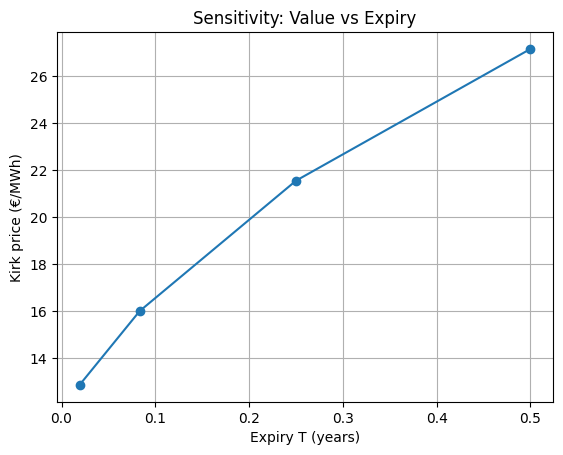

In [18]:
T_list = [1/52, 1/12, 0.25, 0.5]  # ~1w, 1m, 3m, 6m
vals_T = [kirk(S1,S2,sigma1,sigma2,rho,Ti,K) for Ti in T_list]
notionals = [scale_to_capacity(v, 1000, Ti) for v, Ti in zip(vals_T, T_list)]
exp_df = pd.DataFrame({
   "T_years": T_list,
   "kirk_eur_mwh": vals_T,
   "value_1GW_over_T_eur": notionals
})
display(exp_df)

plt.figure()
plt.plot(T_list, vals_T, marker="o")
plt.xlabel("Expiry T (years)")
plt.ylabel("Kirk price (€/MWh)")
plt.title("Sensitivity: Value vs Expiry")
plt.grid(True)
plt.show()